In [90]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import DataLoader, random_split
from tensorflow.keras.utils import image_dataset_from_directory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [47]:
# # Split the dataset into training and validation sets
# path = "data/keras_subset - Copy/" # path to the folder containing the imgs
# cancer_path = path + 'cancer'
# noncancer_path = path + 'non_cancer'
# dataset_len = (len(os.listdir(cancer_path)) + len(os.listdir(noncancer_path)))

# train_size = int(0.8 * dataset_len)
# val_size = dataset_len - train_size
# train_dataset, val_dataset = random_split(path, [train_size, val_size])

In [91]:
train = image_dataset_from_directory(
    'data/tiled_images/keras',
    batch_size=32,
    subset='training',
    seed=123,
    validation_split=0.3
).map(lambda x, y: (x/255, y))

val = image_dataset_from_directory(
    'data/tiled_images/keras',
    batch_size=32,
    subset='validation',
    seed=123,
    validation_split=0.3
).map(lambda x, y: (x/255, y))

Found 378307 files belonging to 2 classes.
Using 264815 files for training.
Found 378307 files belonging to 2 classes.
Using 113492 files for validation.


In [92]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'data/keras_subset - Copy/'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

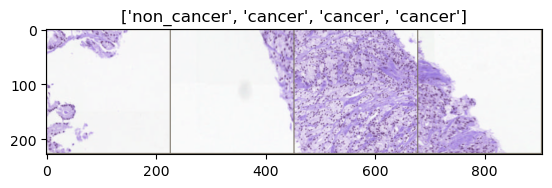

In [77]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [78]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [79]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [80]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [81]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5924 Acc: 0.6852
val Loss: 1.0766 Acc: 0.5750

Epoch 1/24
----------
train Loss: 0.5491 Acc: 0.7731
val Loss: 1.8408 Acc: 0.5250

Epoch 2/24
----------
train Loss: 0.7045 Acc: 0.6898
val Loss: 1.3956 Acc: 0.5250

Epoch 3/24
----------
train Loss: 0.5625 Acc: 0.7593
val Loss: 1.8871 Acc: 0.5000

Epoch 4/24
----------
train Loss: 0.5913 Acc: 0.7639
val Loss: 2.0992 Acc: 0.6000

Epoch 5/24
----------
train Loss: 0.4779 Acc: 0.7685
val Loss: 1.3188 Acc: 0.6125

Epoch 6/24
----------
train Loss: 0.6532 Acc: 0.7269
val Loss: 1.0330 Acc: 0.6375

Epoch 7/24
----------
train Loss: 0.4833 Acc: 0.8009
val Loss: 1.2100 Acc: 0.6375

Epoch 8/24
----------
train Loss: 0.3846 Acc: 0.8472
val Loss: 1.0522 Acc: 0.6375

Epoch 9/24
----------
train Loss: 0.5030 Acc: 0.7593
val Loss: 1.0635 Acc: 0.6125

Epoch 10/24
----------
train Loss: 0.4378 Acc: 0.8194
val Loss: 0.8927 Acc: 0.6375

Epoch 11/24
----------
train Loss: 0.4751 Acc: 0.8056
val Loss: 1.1430 Acc: 0.6125

Ep

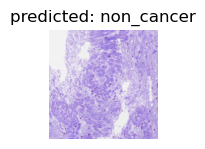

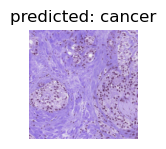

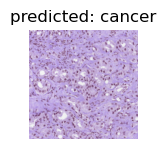

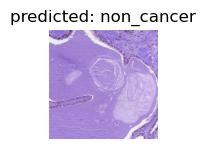

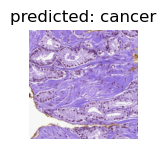

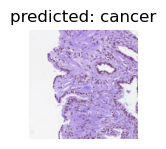

In [82]:
visualize_model(model_ft)

In [83]:
model_conv = torchvision.models.resnet50(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [84]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7159 Acc: 0.5880
val Loss: 0.7923 Acc: 0.5000

Epoch 1/24
----------
train Loss: 0.5476 Acc: 0.7222
val Loss: 0.6911 Acc: 0.7000

Epoch 2/24
----------
train Loss: 0.5733 Acc: 0.7407
val Loss: 0.9161 Acc: 0.5625

Epoch 3/24
----------
train Loss: 0.5410 Acc: 0.7361
val Loss: 1.0973 Acc: 0.5125

Epoch 4/24
----------
train Loss: 0.5747 Acc: 0.7222
val Loss: 0.8598 Acc: 0.5750

Epoch 5/24
----------
train Loss: 0.7306 Acc: 0.6713
val Loss: 0.8275 Acc: 0.5750

Epoch 6/24
----------
train Loss: 0.8204 Acc: 0.6343
val Loss: 0.8931 Acc: 0.5125

Epoch 7/24
----------
train Loss: 0.4365 Acc: 0.8056
val Loss: 0.8312 Acc: 0.5125

Epoch 8/24
----------
train Loss: 0.4633 Acc: 0.8056
val Loss: 0.8664 Acc: 0.5375

Epoch 9/24
----------
train Loss: 0.5116 Acc: 0.7546
val Loss: 0.8337 Acc: 0.5125

Epoch 10/24
----------
train Loss: 0.5066 Acc: 0.7870
val Loss: 0.7920 Acc: 0.5750

Epoch 11/24
----------
train Loss: 0.4666 Acc: 0.7824
val Loss: 0.8191 Acc: 0.5750

Ep

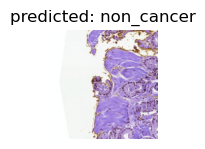

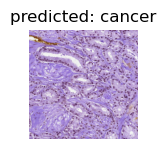

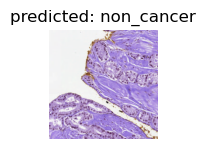

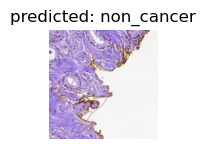

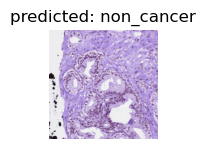

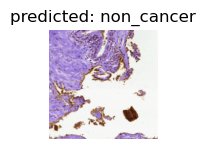

In [85]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [86]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

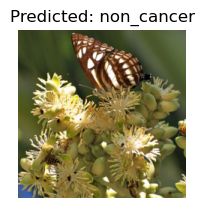

In [88]:
visualize_model_predictions(
    model_conv,
    # img_path='data/keras_subset - Copy/val/cancer/00c15b23b30a5ba061358d9641118904_(1536, 7936)_cancer.png'
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()